# Modelling Data
In this notebook, we will preprocess the data and train various models to predict the rent of a house, and see how they perform.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from scipy.special import inv_boxcox, boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

# Configurations
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Load data
df = pd.read_csv('../data/processed/rent_Valencia.csv', index_col=0)
df.head()

,price,numPhotos,floor,rooms,bathrooms,size,parkingSpacePrice,exterior,renew,new_development,hasParkingSpace,isParkingSpaceIncludedInPrice,isFinished,hasLift,hasPlan,has360,has3DTour,hasVideo,propertyType,cluster
propertyCode,,,,,,,,,,,,,,,,,,,,
97942302,850.0,23,0,5,2,140.0,0.0,False,False,False,False,False,True,False,False,False,False,False,countryHouse,3
97956954,900.0,18,1,3,3,100.0,0.0,True,False,False,True,True,True,True,False,False,False,False,duplex,0
98200619,1200.0,26,2,3,2,145.0,0.0,True,False,False,False,False,True,True,False,False,False,False,flat,0
98015046,1800.0,21,0,3,2,103.0,0.0,True,False,False,False,False,True,True,False,False,False,True,flat,0
97530419,850.0,27,5,3,1,76.0,0.0,False,False,False,False,False,True,True,False,False,False,True,flat,0


In [2]:
# Transform cluster to categorical
df['cluster'] = df['cluster'].map({0: 'central', 1: 'south', 2: 'north', 3: 'west'})

# Function to Box-Cox transform a column
def box_cox_transform(column, lamda= None):
    if lamda is None:
        column, lamda = stats.boxcox(column)
        
        return column, lamda
    else:
        column = boxcox(column, lamda)
        return column

def inv_box_cox_transform(column, lamda):
    column = inv_boxcox(column, lamda)
    return column

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4168 entries, 97942302 to 97996918
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          4168 non-null   float64
 1   numPhotos                      4168 non-null   int64  
 2   floor                          4168 non-null   int64  
 3   rooms                          4168 non-null   int64  
 4   bathrooms                      4168 non-null   int64  
 5   size                           4168 non-null   float64
 6   parkingSpacePrice              4168 non-null   float64
 7   exterior                       4168 non-null   bool   
 8   renew                          4168 non-null   bool   
 9   new_development                4168 non-null   bool   
 10  hasParkingSpace                4168 non-null   bool   
 11  isParkingSpaceIncludedInPrice  4168 non-null   bool   
 12  isFinished                     4168 n

In [4]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

num_col = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_col = X_train.select_dtypes(include=['object']).columns
bool_features = X_train.select_dtypes(include=['bool']).columns

preprocessor = ColumnTransformer(
    [
    ('scaler', StandardScaler(), num_col),
    ('onehot', OneHotEncoder(), cat_col)
    ],
    remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_col)
labels = np.concatenate([num_col, encoded_cat, bool_features])
df_train = pd.DataFrame(X_train, columns=labels, index=train_index)
df_test = pd.DataFrame(X_test, columns=labels, index=test_index)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3334 entries, 97840274 to 97951630
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   numPhotos                      3334 non-null   float64
 1   floor                          3334 non-null   float64
 2   rooms                          3334 non-null   float64
 3   bathrooms                      3334 non-null   float64
 4   size                           3334 non-null   float64
 5   parkingSpacePrice              3334 non-null   float64
 6   propertyType_chalet            3334 non-null   float64
 7   propertyType_countryHouse      3334 non-null   float64
 8   propertyType_duplex            3334 non-null   float64
 9   propertyType_flat              3334 non-null   float64
 10  propertyType_penthouse         3334 non-null   float64
 11  propertyType_studio            3334 non-null   float64
 12  cluster_central                3334 n

So at this point, we have the data preprocessed to into any model. First, we will train our K-means model to predefine the four groups of the data that we will use to train our different models.

In [5]:
kmeans = KMeans(
    n_clusters=4, 
    init='k-means++', 
    max_iter=300, 
    n_init=10, 
    random_state=42
    ).fit(X_train)

df_train['cluster'] = kmeans.labels_
df_train.cluster.value_counts()

1    1539
2    1525
0     248
3      22
Name: cluster, dtype: int64

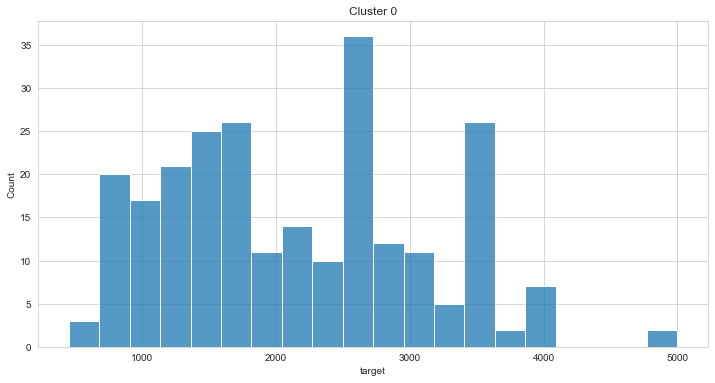

count     248.000000
mean     2132.092742
std       927.308117
min       450.000000
25%      1400.000000
50%      2100.000000
75%      2800.000000
max      5000.000000
Name: target, dtype: float64




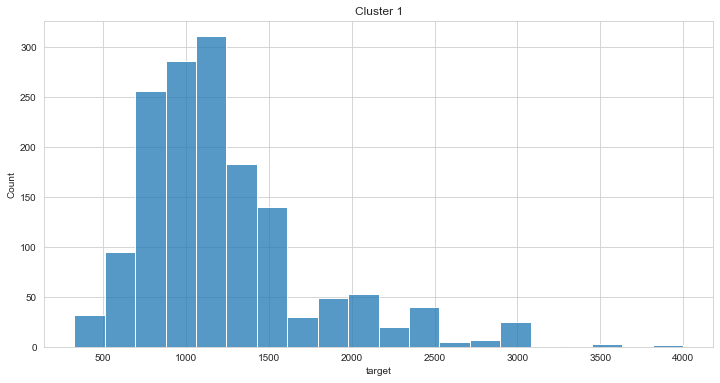

count    1539.000000
mean     1229.011046
std       528.660132
min       325.000000
25%       887.500000
50%      1100.000000
75%      1400.000000
max      4000.000000
Name: target, dtype: float64




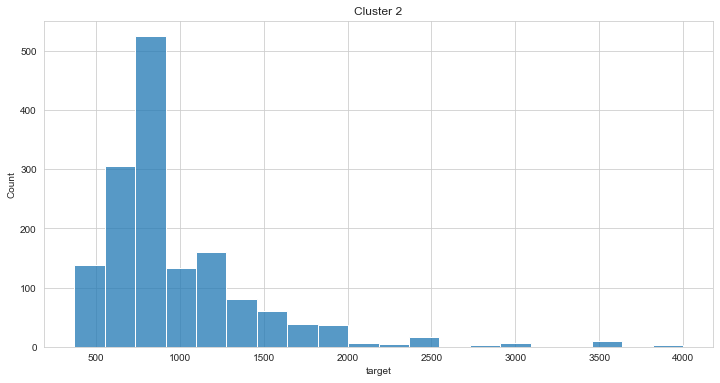

count    1525.000000
mean      977.779672
std       480.580696
min       370.000000
25%       700.000000
50%       850.000000
75%      1100.000000
max      4000.000000
Name: target, dtype: float64




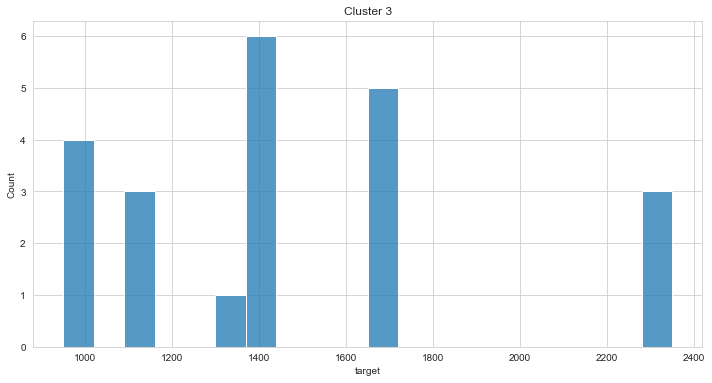

count      22.000000
mean     1467.272727
std       440.614093
min       950.000000
25%      1100.000000
50%      1400.000000
75%      1678.000000
max      2350.000000
Name: target, dtype: float64




In [6]:
# Momentarily, we will append our target variable to the train dataframe
df_train['target'] = y_train

# Separate the groups of data
def separate_cluster(df, cluster):
    df_cluster = df[df['cluster'] == cluster]
    return df_cluster

df_0 = separate_cluster(df_train, 0)
df_1 = separate_cluster(df_train, 1)
df_2 = separate_cluster(df_train, 2)
df_3 = separate_cluster(df_train, 3)

list_df = [df_0, df_1, df_2, df_3]

for n, i in enumerate(list_df):
    # Plot the distribution of the target variable
    plt.figure(figsize=(12, 6))
    sns.histplot(i['target'], bins=20)
    plt.title(f'Cluster {n}')
    plt.show()

    # describe of the target variable
    print(i['target'].describe())
    print('\n')

Maybe the four groups without the target variable are difficult to understand, we will have to study if this really a improvement in our models.

In [7]:
# transform y_train to box-cox
y_train, lamda = box_cox_transform(y_train)

# Reescribe the target variable
df_train['target'] = y_train

df_0 = separate_cluster(df_train, 0)
df_1 = separate_cluster(df_train, 1)
df_2 = separate_cluster(df_train, 2)
df_3 = separate_cluster(df_train, 3)

X0_train, y0_train = df_0.drop(['target', 'cluster'], axis=1), df_0['target']
X1_train, y1_train = df_1.drop(['target', 'cluster'], axis=1), df_1['target']
X2_train, y2_train = df_2.drop(['target', 'cluster'], axis=1), df_2['target']
X3_train, y3_train = df_3.drop(['target', 'cluster'], axis=1), df_3['target']

In order to find the best model, we will train by all the features to find what model to do hyperparameter tuning.

In [8]:
# Import all regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Metrics to evaluate the model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate, RepeatedKFold

list_reg = [
    LinearRegression(), 
    Lasso(), 
    Ridge(), 
    ElasticNet(), 
    DecisionTreeRegressor(), 
    RandomForestRegressor(), 
    GradientBoostingRegressor(), 
    SVR(), 
    KNeighborsRegressor()
    ]

In [9]:
def models_metrics(list_reg, X, y):

    models_metrics = {
        'Model': [],
        'fit_time': [],
        'score_time': [],
        'test_neg_rmse': [],
        'train_neg_rmse': [],
        'test_r2': [],
        'train_r2': [],
        'test_mae': [],
        'train_mae': []
        }

    # Train the models
    for i in list_reg:

        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

        cv_scores = cross_validate(
            estimator=i,
            X=X,
            y=y,
            scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'],
            cv=cv,
            return_train_score=True,
            n_jobs=-1
        )

        models_metrics['Model'].append(i)
        models_metrics['fit_time'].append(cv_scores['fit_time'].mean())
        models_metrics['score_time'].append(cv_scores['score_time'].mean())
        models_metrics['test_neg_rmse'].append(cv_scores['test_neg_root_mean_squared_error'].mean())
        models_metrics['train_neg_rmse'].append(cv_scores['train_neg_root_mean_squared_error'].mean())
        models_metrics['test_r2'].append(cv_scores['test_r2'].mean())
        models_metrics['train_r2'].append(cv_scores['train_r2'].mean())
        models_metrics['test_mae'].append(cv_scores['test_neg_mean_absolute_error'].mean())
        models_metrics['train_mae'].append(cv_scores['train_neg_mean_absolute_error'].mean())

    return models_metrics

### Modelling cluster 0

In [10]:
pd.DataFrame(models_metrics(list_reg, X0_train, y0_train)).sort_values(by='test_r2', ascending=False)

,Model,fit_time,score_time,test_neg_rmse,train_neg_rmse,test_r2,train_r2,test_mae,train_mae
5,RandomForestRegressor(),0.320441,0.014295,-0.014560,-0.005524,0.379793,0.912874,-0.010760,-0.004084
6,GradientBoostingRegressor(),0.069396,0.003734,-0.014997,-0.007227,0.339084,0.850690,-0.011330,-0.005595
8,KNeighborsRegressor(),0.003068,0.198643,-0.015713,-0.012809,0.278511,0.531342,-0.011817,-0.009633
2,Ridge(),0.003867,0.003135,-0.016128,-0.013782,0.238929,0.457918,-0.012611,-0.010989
0,LinearRegression(),0.007335,0.004334,-0.016624,-0.013754,0.188406,0.460089,-0.012930,-0.010949
1,Lasso(),0.003801,0.002934,-0.018711,-0.018725,-0.013817,0.000000,-0.015181,-0.015138
3,ElasticNet(),0.003602,0.002801,-0.018711,-0.018725,-0.013817,0.000000,-0.015181,-0.015138
4,DecisionTreeRegressor(),0.005602,0.003733,-0.018602,-0.000525,-0.023420,0.999110,-0.013533,-0.000078
7,SVR(),0.003868,0.003267,-0.027632,-0.027674,-1.248643,-1.192193,-0.024272,-0.024359


### Modelling cluster 1

In [11]:
pd.DataFrame(models_metrics(list_reg, X1_train, y1_train)).sort_values(by='test_r2', ascending=False)

,Model,fit_time,score_time,test_neg_rmse,train_neg_rmse,test_r2,train_r2,test_mae,train_mae
6,GradientBoostingRegressor(),0.163702,0.004351,-0.015153,-0.012726,0.279976,0.497449,-0.011481,-0.009743
5,RandomForestRegressor(),0.620135,0.030250,-0.015204,-0.005803,0.275957,0.895515,-0.011110,-0.004199
8,KNeighborsRegressor(),0.004268,0.007535,-0.015620,-0.012674,0.235672,0.501484,-0.011686,-0.009417
2,Ridge(),0.004550,0.003230,-0.015842,-0.015449,0.214614,0.259672,-0.012054,-0.011781
0,LinearRegression(),0.007067,0.003134,-0.015854,-0.015447,0.213380,0.259878,-0.012056,-0.011773
1,Lasso(),0.004667,0.003134,-0.017966,-0.017957,-0.006703,0.000000,-0.014006,-0.013990
3,ElasticNet(),0.004602,0.003002,-0.017966,-0.017957,-0.006703,0.000000,-0.014006,-0.013990
4,DecisionTreeRegressor(),0.009336,0.003467,-0.020539,-0.001299,-0.325487,0.994685,-0.014433,-0.000200
7,SVR(),0.004134,0.003068,-0.022639,-0.022581,-0.613560,-0.584225,-0.018528,-0.018505


### Modelling cluster 2

In [12]:
pd.DataFrame(models_metrics(list_reg, X2_train, y2_train)).sort_values(by='test_r2', ascending=False)

,Model,fit_time,score_time,test_neg_rmse,train_neg_rmse,test_r2,train_r2,test_mae,train_mae
5,RandomForestRegressor(),0.583607,0.026609,-1.679286e-02,-0.006416,2.325024e-01,0.888909,-1.256532e-02,-0.004735
6,GradientBoostingRegressor(),0.165490,0.003601,-1.693819e-02,-0.014615,2.204063e-01,0.423653,-1.275249e-02,-0.011043
2,Ridge(),0.004231,0.002965,-1.756553e-02,-0.017116,1.615682e-01,0.209577,-1.332145e-02,-0.013011
8,KNeighborsRegressor(),0.003334,0.008003,-1.792861e-02,-0.014490,1.248571e-01,0.433488,-1.352639e-02,-0.010977
1,Lasso(),0.004802,0.003534,-1.926425e-02,-0.019253,-6.343069e-03,0.000000,-1.489249e-02,-0.014876
3,ElasticNet(),0.003963,0.002865,-1.926425e-02,-0.019253,-6.343069e-03,0.000000,-1.489249e-02,-0.014876
7,SVR(),0.004468,0.003001,-1.937795e-02,-0.019384,-1.836957e-02,-0.013587,-1.523250e-02,-0.015226
4,DecisionTreeRegressor(),0.011203,0.003333,-2.280970e-02,-0.001555,-4.187690e-01,0.993064,-1.649656e-02,-0.000224
0,LinearRegression(),0.007202,0.002867,-1.606076e+10,-0.017139,-1.067165e+25,0.207392,-1.300563e+09,-0.013009


### Modelling cluster 3

In [13]:
pd.DataFrame(models_metrics(list_reg, X3_train, y3_train)).sort_values(by='test_r2', ascending=False)

,Model,fit_time,score_time,test_neg_rmse,train_neg_rmse,test_r2,train_r2,test_mae,train_mae
2,Ridge(),0.003067,0.003534,-0.006401,-0.003400,0.429267,0.909986,-0.004960,-0.002514
5,RandomForestRegressor(),0.183844,0.011738,-0.006587,-0.002765,0.410587,0.941045,-0.004935,-0.001782
8,KNeighborsRegressor(),0.002267,0.002868,-0.007788,-0.006393,0.093489,0.688966,-0.006416,-0.004832
6,GradientBoostingRegressor(),0.037076,0.002934,-0.006373,-0.000002,0.081325,1.000000,-0.004283,-0.000001
4,DecisionTreeRegressor(),0.002601,0.002469,-0.007242,0.000000,-0.240855,1.000000,-0.004346,0.000000
7,SVR(),0.002869,0.002667,-0.011331,-0.011718,-0.552371,-0.024871,-0.009157,-0.009295
0,LinearRegression(),0.003401,0.002534,-0.011821,-0.002027,-0.697761,0.965507,-0.008634,-0.001515
1,Lasso(),0.002868,0.002799,-0.011736,-0.011583,-0.836103,0.000000,-0.009519,-0.009238
3,ElasticNet(),0.002600,0.002534,-0.011736,-0.011583,-0.836103,0.000000,-0.009519,-0.009238


### Modelling without cluster

In [14]:
pd.DataFrame(models_metrics(list_reg, X_train, y_train)).sort_values(by='test_r2', ascending=False)

,Model,fit_time,score_time,test_neg_rmse,train_neg_rmse,test_r2,train_r2,test_mae,train_mae
5,RandomForestRegressor(),1.100793,0.032351,-0.015698,-0.005975,0.423388,0.916576,-0.011594,-0.004371
6,GradientBoostingRegressor(),0.320228,0.002371,-0.015870,-0.014695,0.410751,0.495439,-0.012077,-0.011201
8,KNeighborsRegressor(),0.001469,0.015334,-0.016656,-0.013447,0.350952,0.577521,-0.012517,-0.010082
2,Ridge(),0.002334,0.001133,-0.016739,-0.016569,0.344416,0.358564,-0.012892,-0.012780
0,LinearRegression(),0.005268,0.001600,-0.016741,-0.016566,0.344214,0.358809,-0.012887,-0.012771
1,Lasso(),0.003533,0.001066,-0.020692,-0.020688,-0.001351,0.000000,-0.016685,-0.016679
3,ElasticNet(),0.003667,0.001067,-0.020692,-0.020688,-0.001351,0.000000,-0.016685,-0.016679
4,DecisionTreeRegressor(),0.014735,0.001667,-0.021874,-0.001394,-0.122130,0.995388,-0.015532,-0.000200
7,SVR(),0.002399,0.001134,-0.022037,-0.022071,-0.136030,-0.138927,-0.017418,-0.017444


Random Forest Regressor seems to be the best model for this dataset, let them with the test set.

In [15]:
def test_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    real_test = inv_box_cox_transform(y_test, lamda)
    real_pred = inv_box_cox_transform(y_pred, lamda)

    result = {
        'real': real_test,
        'predicted': real_pred,
        'error': real_test - real_pred
    }
    
    rmse = np.sqrt(mean_squared_error(real_test, real_pred))
    r2 = r2_score(real_test, real_pred)
    mae = mean_absolute_error(real_test, real_pred)

    return pd.DataFrame(result), rmse, r2, mae

model = RandomForestRegressor()

y_test = box_cox_transform(y_test, lamda)

df_test['cluster'] = kmeans.predict(X_test)
df_test['target'] = y_test


df_0 = separate_cluster(df_test, 0)
df_1 = separate_cluster(df_test, 1)
df_2 = separate_cluster(df_test, 2)
df_3 = separate_cluster(df_test, 3)

X0_test, y0_test = df_0.drop(['target', 'cluster'], axis=1), df_0['target']
X1_test, y1_test = df_1.drop(['target', 'cluster'], axis=1), df_1['target']
X2_test, y2_test = df_2.drop(['target', 'cluster'], axis=1), df_2['target']
X3_test, y3_test = df_3.drop(['target', 'cluster'], axis=1), df_3['target']

### Test for cluster 0

In [16]:
t0, rmse, r2, mae = test_model(model, X0_train, y0_train, X0_test, y0_test)
t0.sample(5)

,real,predicted,error
propertyCode,,,
95032823,1500.0,2525.622222,-1025.622222
96901935,3500.0,3337.995804,162.004196
98038953,1500.0,1547.295740,-47.295740
98028193,1855.0,1979.657896,-124.657896
98276288,2000.0,1481.520389,518.479611


In [17]:
print('RMSE:', rmse)
print('R2:', r2)
print('MAE:', mae)

RMSE: 628.6681315880139
R2: 0.3223328432624887
MAE: 486.0076735730647


### Test for cluster 1

In [18]:
t1, rmse, r2, mae = test_model(model, X1_train, y1_train, X1_test, y1_test)
t1.sample(5)

,real,predicted,error
propertyCode,,,
98274324,1200.0,1093.417701,106.582299
36839452,630.0,794.106284,-164.106284
89977279,1300.0,1478.511150,-178.511150
98195699,550.0,632.108682,-82.108682
98083237,1500.0,1124.352788,375.647212


In [19]:
print('RMSE:', rmse)
print('R2:', r2)
print('MAE:', mae)

RMSE: 469.0098544801432
R2: 0.2372553319401397
MAE: 307.41006104365084


### Test for cluster 2

In [20]:
t2, rmse, r2, mae = test_model(model, X2_train, y2_train, X2_test, y2_test)
t2.sample(5)

,real,predicted,error
propertyCode,,,
96418453,600.0,736.551588,-136.551588
98038269,800.0,869.623835,-69.623835
98321982,600.0,754.366920,-154.366920
94396615,600.0,737.872544,-137.872544
96450740,850.0,807.189798,42.810202


In [21]:
print('RMSE:', rmse)
print('R2:', r2)
print('MAE:', mae)

RMSE: 445.3197809345724
R2: 0.09973344866008338
MAE: 274.8669064057195


### Test for cluster 3

In [22]:
X3_test

,numPhotos,floor,rooms,bathrooms,size,parkingSpacePrice,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,cluster_central,cluster_north,cluster_south,cluster_west,exterior,renew,new_development,hasParkingSpace,isParkingSpaceIncludedInPrice,isFinished,hasLift,hasPlan,has360,has3DTour,hasVideo
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,
97515708,0.727436,1.050480,0.219366,-0.935119,-0.429295,10.451963,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
93068423,0.237284,0.317704,0.219366,0.489783,0.340820,13.615209,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


In [23]:
t3, rmse, r2, mae = test_model(model, X3_train, y3_train, X3_test, y3_test)
t3.sample(2)

,real,predicted,error
propertyCode,,,
93068423,1678.0,1701.341574,-23.341574
97515708,1100.0,1104.914623,-4.914623


In [24]:
print('RMSE:', rmse)
print('R2:', r2)
print('MAE:', mae)

RMSE: 16.866869900379672
R2: 0.996593775215379
MAE: 14.128098710765016


### Test without cluster

In [25]:
t, rmse, r2, mae = test_model(model, X_train, y_train, X_test, y_test)
t.sample(5)

,real,predicted,error
propertyCode,,,
97699947,1100.0,864.941975,235.058025
97927836,1900.0,1203.989665,696.010335
98316107,830.0,870.826651,-40.826651
98340079,800.0,851.602966,-51.602966
97800756,1250.0,1201.711269,48.288731


In [26]:
print('RMSE:', rmse)
print('R2:', r2)
print('MAE:', mae)

RMSE: 466.38710069179655
R2: 0.3769924130389839
MAE: 298.65082894414843


So the cluster do not have a significant impact on the model. Maybe it would be a better approach to use just 2 clusters, let's try it.

In [27]:
kmeans = KMeans(
    n_clusters=2, 
    init='k-means++', 
    max_iter=300, 
    n_init=10, 
    random_state=42
    ).fit(X_train)

df_train['cluster'] = kmeans.labels_
df_train.cluster.value_counts()

1    1819
0    1515
Name: cluster, dtype: int64

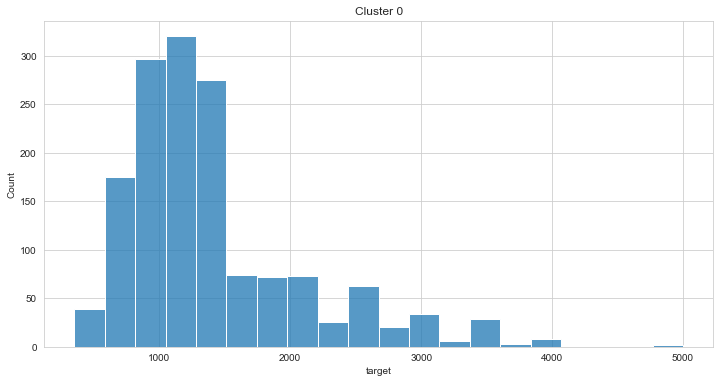

count    1515.000000
mean     1406.803300
std       690.486027
min       350.000000
25%       950.000000
50%      1200.000000
75%      1600.000000
max      5000.000000
Name: target, dtype: float64




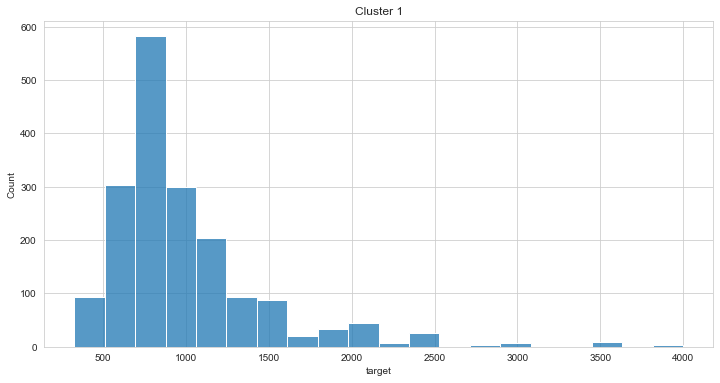

count    1819.000000
mean      996.313359
std       486.246034
min       325.000000
25%       700.000000
50%       850.000000
75%      1100.000000
max      4000.000000
Name: target, dtype: float64




In [28]:
# Momentarily, we will append our target variable to the train dataframe
df_train['target'] = inv_box_cox_transform(y_train, lamda)

# Separate the groups of data
def separate_cluster(df, cluster):
    df_cluster = df[df['cluster'] == cluster]
    return df_cluster

df_0 = separate_cluster(df_train, 0)
df_1 = separate_cluster(df_train, 1)

list_df = [df_0, df_1]

for n, i in enumerate(list_df):
    # Plot the distribution of the target variable
    plt.figure(figsize=(12, 6))
    sns.histplot(i['target'], bins=20)
    plt.title(f'Cluster {n}')
    plt.show()

    # describe of the target variable
    print(i['target'].describe())
    print('\n')

These two clusters sees like a one group of majority of prices between 500 and 1000, and the other group have higher prices.

In [29]:
df_train['target'] = y_train

df_0 = separate_cluster(df_train, 0)
df_1 = separate_cluster(df_train, 1)

X0_train, y0_train = df_0.drop(['target', 'cluster'], axis=1), df_0['target']
X1_train, y1_train = df_1.drop(['target', 'cluster'], axis=1), df_1['target']

df_test['cluster'] = kmeans.predict(X_test)
df_test['target'] = y_test

df_0 = separate_cluster(df_test, 0)
df_1 = separate_cluster(df_test, 1)

X0_test, y0_test = df_0.drop(['target', 'cluster'], axis=1), df_0['target']
X1_test, y1_test = df_1.drop(['target', 'cluster'], axis=1), df_1['target']

### Modelling cluster 0

In [30]:
pd.DataFrame(models_metrics(list_reg, X0_train, y0_train)).sort_values(by='test_r2', ascending=False)

,Model,fit_time,score_time,test_neg_rmse,train_neg_rmse,test_r2,train_r2,test_mae,train_mae
6,GradientBoostingRegressor(),0.164152,0.003973,-0.014724,-0.012603,0.405502,0.566767,-0.011272,-0.009637
5,RandomForestRegressor(),0.584641,0.023946,-0.014776,-0.005576,0.401337,0.915195,-0.010949,-0.004072
8,KNeighborsRegressor(),0.003733,0.008936,-0.015306,-0.012415,0.357790,0.579660,-0.011655,-0.009354
2,Ridge(),0.004202,0.002800,-0.015922,-0.015378,0.304721,0.355106,-0.012244,-0.011893
0,LinearRegression(),0.007201,0.003735,-0.015927,-0.015369,0.304285,0.355844,-0.012241,-0.011878
1,Lasso(),0.004868,0.002868,-0.019149,-0.019151,-0.003323,0.000000,-0.014871,-0.014858
3,ElasticNet(),0.003667,0.002535,-0.019149,-0.019151,-0.003323,0.000000,-0.014871,-0.014858
4,DecisionTreeRegressor(),0.009268,0.002534,-0.019658,-0.001154,-0.062164,0.996311,-0.013880,-0.000168
7,SVR(),0.004467,0.002801,-0.022791,-0.022850,-0.430390,-0.430410,-0.018392,-0.018443


### Modelling cluster 1

In [31]:
pd.DataFrame(models_metrics(list_reg, X1_train, y1_train)).sort_values(by='test_r2', ascending=False)

,Model,fit_time,score_time,test_neg_rmse,train_neg_rmse,test_r2,train_r2,test_mae,train_mae
5,RandomForestRegressor(),0.642199,0.022578,-0.016640,-0.006348,0.250536,0.891293,-0.012346,-0.004654
6,GradientBoostingRegressor(),0.181708,0.003537,-0.016810,-0.014725,0.234900,0.415010,-0.012665,-0.011143
2,Ridge(),0.004602,0.002933,-0.017412,-0.017070,0.179450,0.213897,-0.013292,-0.013046
0,LinearRegression(),0.007669,0.003067,-0.017459,-0.017057,0.174847,0.215105,-0.013310,-0.013025
8,KNeighborsRegressor(),0.004334,0.008346,-0.017701,-0.014347,0.151537,0.444678,-0.013405,-0.010809
1,Lasso(),0.004934,0.003401,-0.019255,-0.019254,-0.001718,0.000000,-0.014920,-0.014916
3,ElasticNet(),0.004467,0.002534,-0.019255,-0.019254,-0.001718,0.000000,-0.014920,-0.014916
7,SVR(),0.004334,0.002935,-0.019534,-0.019568,-0.031110,-0.032945,-0.014933,-0.014972
4,DecisionTreeRegressor(),0.010536,0.002866,-0.022595,-0.001541,-0.384703,0.993471,-0.016282,-0.000222


### Test for cluster 0

In [36]:
model = GradientBoostingRegressor()
t0, rmse, r2, mae = test_model(model, X0_train, y0_train, X0_test, y0_test)
t0.sample(10)

,real,predicted,error
propertyCode,,,
83948900,1450.0,1484.735134,-34.735134
86954803,850.0,1101.869785,-251.869785
97982361,1500.0,1112.585110,387.414890
98204133,1500.0,1312.937111,187.062889
97926718,1695.0,1201.790150,493.209850
97975265,1100.0,1013.790961,86.209039
97634553,600.0,977.792466,-377.792466
98260398,1050.0,1070.925800,-20.925800
97839794,925.0,1232.986678,-307.986678


In [37]:
print('RMSE:', rmse)
print('R2:', r2)
print('MAE:', mae)

RMSE: 524.9195593063533
R2: 0.34846889279867077
MAE: 355.8074825142092


### Test for cluster 1

In [38]:
model = RandomForestRegressor()
t1, rmse, r2, mae = test_model(model, X1_train, y1_train, X1_test, y1_test)
t1.sample(10)

,real,predicted,error
propertyCode,,,
98316107,830.0,881.312735,-51.312735
94823279,800.0,886.078202,-86.078202
35563634,900.0,912.368218,-12.368218
86811403,1300.0,1079.237686,220.762314
85319686,1600.0,847.677378,752.322622
98158021,560.0,870.252934,-310.252934
38971159,725.0,881.790387,-156.790387
97810685,890.0,691.167003,198.832997
98007321,950.0,804.149784,145.850216


In [39]:
print('RMSE:', rmse)
print('R2:', r2)
print('MAE:', mae)

RMSE: 447.6268059491428
R2: 0.0813642844661121
MAE: 274.2373307184943


### Conclusion

* There no really a significant improvement in the model, so we will use the model without cluster.
* The best model is the Random Forest Regressor.